## circle negative-log-likelihood plots

In [1]:
import os
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

os.environ['CUDA_VISIBLE_DEVICES']='0' # can be 0-6 - check it's free

import jax
# jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
from jax.scipy.special import logsumexp

import matplotlib.pyplot as plt
import numpy as np

from functools import partial

from src.diffusion import VE_diffuser, log_hat_pt, empirical_score_fn, empirical_eps_fn, sample_rev

# plot formatting
import seaborn as sns
from matplotlib.lines import Line2D
sns.set_theme()  # sets a nicer global style for plots
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif'})

## define diffusion model objects

In [2]:
ve = VE_diffuser(sigma_min=0.001, sigma_max=3.0)

In [3]:
def sample_curve(J, curve_fn, sampling_mode="equally_spaced", return_thetas=False, rng=None, endpoint=False):
    if sampling_mode == "equally_spaced":
        ts = jnp.linspace(0, 2 * jnp.pi, 1000)
        points = jax.vmap(curve_fn)(ts)
        segment_lengths = jnp.sqrt(jnp.sum(jnp.diff(points, axis=0)**2, axis=1))
        arc_lengths = jnp.concatenate([jnp.array([0]), jnp.cumsum(segment_lengths)])
        normalized_arc_lengths = arc_lengths / arc_lengths[-1]
        target_arc_lengths = jnp.linspace(0, 1, J, endpoint=endpoint)
        thetas = jnp.interp(target_arc_lengths, normalized_arc_lengths, ts)
    elif sampling_mode == "uniform_theta":
        thetas = jnp.linspace(0, 2 * jnp.pi, J, endpoint=endpoint)       
    elif sampling_mode == "random":
        thetas = jax.random.uniform(rng, (J,), minval=0, maxval=2 * jnp.pi)

    elif sampling_mode == "uniform_random":
        N = 5000
        ts = jnp.linspace(0, 2 * jnp.pi, N)
        points = jax.vmap(curve_fn)(ts)
        segment_lengths = jnp.sqrt(jnp.sum(jnp.diff(points, axis=0)**2, axis=1))
        arc_lengths = jnp.concatenate([jnp.array([0]), jnp.cumsum(segment_lengths)])
        normalized_arc_lengths = arc_lengths / arc_lengths[-1]
        target_arc_lengths = jnp.linspace(0, 1, N, endpoint=endpoint)
        uniform_spaces_thetas = jnp.interp(target_arc_lengths, normalized_arc_lengths, ts)
        thetas = jax.random.choice(rng, uniform_spaces_thetas, shape=(J,), replace=False)
    
    points = jax.vmap(curve_fn)(thetas)

    if return_thetas:
        return points, thetas
    else:
        return points

def get_ellipse_curve_fn(a, b, scale):
    def ellipse_curve_fn(theta):
        x = scale * a * jnp.cos(theta)
        y = scale * b * jnp.sin(theta)
        return jnp.array([x, y])

    return ellipse_curve_fn


def get_smoothed_fn(func, sigma, n=1000):
    """
    Return a smoothed version of `func` by convolving with a Gaussian kernel.
    """
    @jax.jit
    def smoothed_func(x, t, key):
        zs = jax.random.normal(key, shape=(n, *x.shape))
        # Generate the offsets for the mesh grid
        offsets = sigma * zs
        # Shift the point x by each offset in the meshgrid
        shifted_points = x + offsets
        # Evaluate func at each of these shifted points
        vals = jax.vmap(lambda offset: func(offset, t, key))(shifted_points)
        # Return the mean of these values
        return jnp.mean(vals, axis=0)
    
    return smoothed_func

## define log-likelihood calculation with the probability-flow ODE
- perform initial testing of the log-likelihood calculation

In [ ]:
import jax
import jax.numpy as jnp
from functools import partial

# Assume 've' is an object with methods like g_t(t), v_t(t), T, and attribute d (dimension)
# Assume 'score_fn' is the function provided: score_fn(x, time, key)

@partial(jax.jit, static_argnums=(0, 2, 3))
def log_likelihood_rev_prob_flow(ve, xs_0, score_fn, n_steps=1000, epsilon=1e-3):
    """
    Computes the log-likelihood of data points xs_0 using the Probability Flow ODE.

    Args:
        ve: Variance exploding diffusion model object
        xs_0: Batch of data points ( B, D )
        score_fn: The score function score(x, t, key)
        n_steps: Number of integration steps
        epsilon: Small time offset to avoid score computation issues at t=0

    Returns:
        A JAX array of log-likelihoods for each point in xs_0 ( B, ).
    """
    batch_size = xs_0.shape[0]
    dim = xs_0.shape[1]

    # Define the divergence function using autodiff
    def divergence_fn(x, t, key):
        # Define a function of x only for jacobian calculation
        score_at_t = lambda x_: score_fn(x_, t, key)
        jac = jax.jacfwd(score_at_t)(x)
        return jnp.trace(jac)

    # Define the ODE step function for jax.lax.scan
    def ode_step(carry, time_step):
        x_tm1, log_p_change_acc, rng = carry
        t_prev, t_curr = time_step

        dt = t_curr - t_prev
        # Use a dummy key for score evaluation, as the score function requires one.
        rng, key = jax.random.split(rng)

        # Evaluate score and divergence at the start of the interval (t_prev)
        score_val = score_fn(x_tm1, t_prev, key)
        div_val = divergence_fn(x_tm1, t_prev, key)

        # Forward ODE update (Euler-Maruyama step)
        drift = -0.5 * ve.g_t(t_prev)**2 * score_val
        x_t = x_tm1 + drift * dt

        # Update log-likelihood change
        log_p_step = 0.5 * ve.g_t(t_prev)**2 * div_val * dt
        log_p_change_acc = log_p_change_acc + log_p_step

        return (x_t, log_p_change_acc, rng), log_p_change_acc

    # Time steps
    powers = jnp.linspace(0, 1, n_steps + 1)
    ts = epsilon * (ve.T / epsilon)**powers
    
    time_steps = jnp.stack([ts[:-1], ts[1:]], axis=1) # Create pairs (t_prev, t_curr)

    # Vmap the ODE integration over the batch
    def single_log_likelihood(x_0, base_rng):
        # Initial state for scan
        init_carry = (x_0, 0.0, base_rng) # x(0), accumulated_log_p_change=0, rng

        # Run the ODE integration
        (x_T, log_p_change_total, _), log_p_traj = jax.lax.scan(
            ode_step, init_carry, time_steps
        )

        # Calculate log prob of x_T under the prior N(0, v(T) * I)
        v_T = ve.v_t(ve.T)
        log_p_xT = -0.5 * (dim * jnp.log(2 * jnp.pi * v_T) + jnp.sum(x_T**2) / v_T)

        # Final log likelihood: log p(x(0)) = log p(x(T)) - integral
        log_likelihood = log_p_xT - log_p_change_total
        log_likelihood_traj = log_p_xT - log_p_traj
        return x_T, log_likelihood, log_likelihood_traj

    # Vmap over the batch dimension of xs_0
    batch_rngs = jax.random.split(jax.random.PRNGKey(0), batch_size)
    log_likelihoods = jax.vmap(single_log_likelihood)(xs_0, batch_rngs)

    return log_likelihoods

In [5]:
# define the curve function which defines the manifold
a = 1
b = 1
scale = 1
curve_fn = get_ellipse_curve_fn(a, b, scale)

DATA_SIZE = 12
Data, thetas = sample_curve(DATA_SIZE, curve_fn, sampling_mode="equally_spaced", return_thetas=True)

# approx to true manifold
Curve = sample_curve(5000, curve_fn, sampling_mode="uniform_theta")

# define the empirical score functions, and a 'true' score function (using lots of points)
continuous_score = lambda x, t, key : empirical_score_fn(x, Curve, t)
empirical_score = lambda x, t, key : empirical_score_fn(x, Data, t)

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/howard/python_envs/jax/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/howard/python_envs/jax/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'
2026-01-03 16:56:22.386147: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


#### First, check that the empirical score function behaves as expected
- get 100 points on the curve, and work out their negative log-likelihoods under the empirical score function diffusion model
- these should be low for points near the training data, and high for points away from the training data

[-2.6466417  -0.6221876   5.379373   15.299103   29.08032    19.467396
  8.25309     0.94002056 -2.4200892  -1.7434516   2.9411082  11.560259
 24.062939   24.062988   11.560282    2.9411392  -1.7434411  -2.4200954
  0.93999624  8.253044   19.467333   29.080326   15.2991085   5.379376
 -0.6221857  -2.6466422  -0.6221943   5.379365   15.299087   29.080303
 19.467384    8.253086    0.94001365 -2.420093   -1.7434449   2.9411283
 11.560276   24.06299    24.063059   11.560316    2.9411511  -1.7434306
 -2.4200983   0.93999505  8.253045   19.467339   29.080334   15.299109
  5.379382   -0.6221757  -2.6466417  -0.62220526  5.379353   15.299057
 29.080284   19.467422    8.253111    0.9400244  -2.4200873  -1.7434564
  2.9410868  11.560202   24.062881   24.062937   11.560243    2.9411054
 -1.7434554  -2.4200864   0.94002914  8.253122   19.46743    29.080341
 15.29911     5.379379   -0.62218523 -2.6466413  -0.6222224   5.3793197
 15.299012   29.080225   19.46743     8.253113    0.9400284  -2.4200869

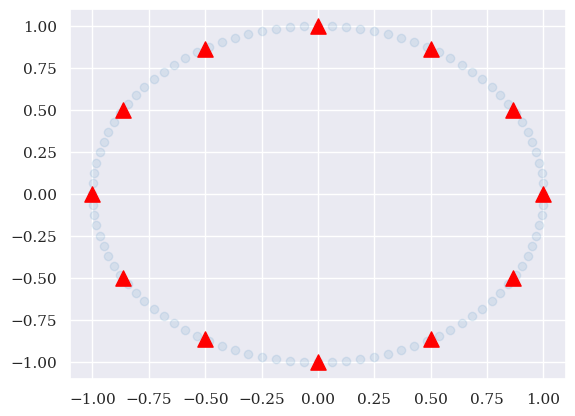

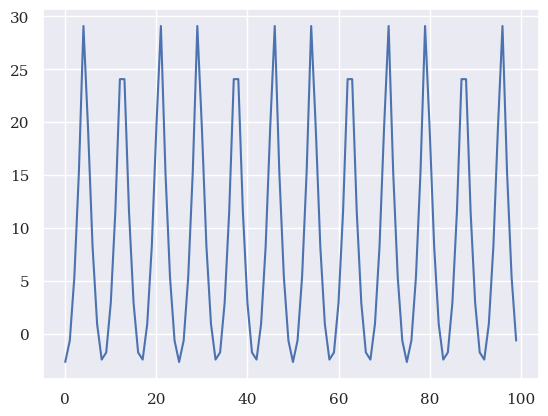

In [20]:
start_data = sample_curve(100, curve_fn, sampling_mode="uniform_theta")

sigma_min = jnp.sqrt(1e-3)
sigma_max = jnp.sqrt(5.0)
ve = VE_diffuser(sigma_min=sigma_min, sigma_max=sigma_max)

xT, log_lik, log_lik_traj = log_likelihood_rev_prob_flow(ve, start_data, empirical_score, n_steps=1000, epsilon=1e-3)
print(-log_lik)

plt.scatter(start_data[:, 0], start_data[:, 1], alpha=0.1, c='tab:blue')
plt.scatter(Data[:, 0], Data[:, 1], alpha=1, c='red', s=120, marker="^")
plt.show()

plt.plot(-log_lik)
plt.show()

# the lowest negative log likelihoods coincide with the datapoints, as expected

#### now verify that the 'true' score function behaves as expected
- perform the data as above, but now with the 'true' score function (approximated using the empirical score function for lots of points)
- now, the negative log-likelihoods should be approximately constant

In [24]:
# and instead sampling with the 'true' score function (approximated using empirical score for lots of points)
start_data = sample_curve(100, curve_fn, sampling_mode="uniform_theta")

xT, log_lik, log_lik_traj = log_likelihood_rev_prob_flow(ve, start_data, continuous_score, n_steps=1000, epsilon=1e-3)
print(-log_lik)

# these are all now the same, as they should be

[-0.74119854 -0.74119806 -0.7411995  -0.74120045 -0.7412     -0.74119854
 -0.741199   -0.7411995  -0.74119806 -0.7412014  -0.74120045 -0.7411995
 -0.7412     -0.7412009  -0.7411995  -0.7411995  -0.7412014  -0.74119854
 -0.7412     -0.74119854 -0.7411995  -0.7411995  -0.7412009  -0.7411995
 -0.74119806 -0.74120045 -0.74119854 -0.7411995  -0.7412009  -0.7412
 -0.74119806 -0.7411976  -0.741199   -0.7411971  -0.7412014  -0.7412
 -0.7412     -0.7412014  -0.7412009  -0.7411995  -0.7411995  -0.7412009
 -0.7411976  -0.7411995  -0.74119854 -0.7411995  -0.7411995  -0.7412009
 -0.7412     -0.741199   -0.74120045 -0.74119854 -0.741199   -0.7412
 -0.7411995  -0.7411995  -0.7411995  -0.741199   -0.74119854 -0.7412014
 -0.74120045 -0.7411995  -0.74120045 -0.7412014  -0.7411995  -0.74120045
 -0.7412009  -0.74119854 -0.7411995  -0.74119854 -0.74119806 -0.74119806
 -0.74120045 -0.7411995  -0.74119806 -0.7412     -0.74119854 -0.741199
 -0.7412009  -0.74120045 -0.7411976  -0.741199   -0.74119854 -0.741199

## smoothing the log likelihood
- now perform the same calculation, but using a smoothed score function

In [29]:
import jax
import jax.numpy as jnp
from functools import partial

# @partial(jax.jit, static_argnums=(0, 2, 3))
def log_likelihood_rev_prob_flow_smoothing(ve, xs_0, score_fn, smoothed_score_fn, n_steps=1000, epsilon=1e-3, n_smoothing=200, smoothing_param=0.5):
    """
    Computes the log-likelihood of data points xs_0 using the Probability Flow ODE.

    Args:
        ve: Variance exploding diffusion model object
        xs_0: Batch of data points ( B, D )
        score_fn: The score function score(x, t, key) (needed for computing the divergence, which is then smoothed)
        smoothed_score_fn: The smoothed score function
        n_steps: Number of integration steps
        epsilon: Small time offset to avoid issues at t=0 and t=T

    Returns:
        A JAX array of log-likelihoods for each point in xs_0 ( B, ).
    """
    batch_size = xs_0.shape[0]
    dim = xs_0.shape[1]

    # Define the divergence function using autodiff
    # NOTE: This takes the empirical score function, and returns the divergence
    # The divergence is then smoothed (because convolution interchanges with divergence operator)
    unused_key = jax.random.PRNGKey(0)
    def divergence_fn(x, t):
        # Define a function of x only for jacobian calculation
        score_at_t = lambda x_: score_fn(x_, t, unused_key)
        jac = jax.jacfwd(score_at_t)(x)
        return jnp.trace(jac)
    
    smoothed_divergence = get_smoothed_fn(lambda x, t, key: divergence_fn(x, t), smoothing_param, n_smoothing)

    # Define the ODE step function for jax.lax.scan
    def ode_step(carry, time_step):
        x_tm1, log_p_change_acc, rng = carry
        t_prev, t_curr = time_step

        dt = t_curr - t_prev
        # Use a dummy key for score evaluation, as the score function requires one.
        rng, key1, key2 = jax.random.split(rng, 3)

        # Evaluate score and divergence at the start of the interval (t_prev)
        score_val = smoothed_score_fn(x_tm1, t_prev, key1)
        div_val = smoothed_divergence(x_tm1, t_prev, key2)

        # Forward ODE update (Euler-Maruyama step)
        drift = -0.5 * ve.g_t(t_prev)**2 * score_val
        x_t = x_tm1 + drift * dt

        # Update log-likelihood change
        log_p_step = 0.5 * ve.g_t(t_prev)**2 * div_val * dt
        log_p_change_acc = log_p_change_acc + log_p_step

        return (x_t, log_p_change_acc, rng), log_p_change_acc

    # Time steps from epsilon to T-epsilon
    powers = jnp.linspace(0, 1, n_steps + 1)
    ts = epsilon * (ve.T / epsilon)**powers

    time_steps = jnp.stack([ts[:-1], ts[1:]], axis=1) # Create pairs (t_prev, t_curr)

    # Vmap the ODE integration over the batch
    def single_log_likelihood(x_0, base_rng):
        # Initial state for scan
        init_carry = (x_0, 0.0, base_rng) # x(0), accumulated_log_p_change=0, rng

        # Run the ODE integration
        (x_T, log_p_change_total, _), log_p_traj = jax.lax.scan(
            ode_step, init_carry, time_steps
        )

        # Calculate log prob of x_T under the prior N(0, v(T) * I)
        v_T = ve.v_t(ve.T)
        log_p_xT = -0.5 * (dim * jnp.log(2 * jnp.pi * v_T) + jnp.sum(x_T**2) / v_T)

        # Final log likelihood: log p(x(0)) = log p(x(T)) - integral
        log_likelihood = log_p_xT - log_p_change_total
        log_likelihood_traj = log_p_xT - log_p_traj
        return x_T, log_likelihood, log_likelihood_traj


    # Vmap over the batch dimension of xs_0
    batch_rngs = jax.random.split(jax.random.PRNGKey(0), batch_size)
    log_likelihoods = jax.vmap(single_log_likelihood)(xs_0, batch_rngs)

    return log_likelihoods

[-0.09776306 -0.05264235  0.07883215  0.15282202  0.13549757  0.14058256
  0.12691355 -0.03558445 -0.10193443 -0.06088734  0.05158854  0.12057352
  0.23900747  0.26189327  0.18713808  0.04734182 -0.11421776 -0.02699614
 -0.00818253  0.0652914   0.19961405  0.2670393   0.24948978  0.05638456
 -0.01144457 -0.02981949 -0.0644722   0.03191757  0.19320107  0.20904303
  0.10275507  0.04886913  0.02854395 -0.06951141 -0.06372881  0.06307173
  0.1052494   0.29811096  0.22973108  0.13726664  0.03823948 -0.01616716
  0.00183153 -0.04821444  0.11897039  0.18356228  0.33917093  0.236938
  0.08503675 -0.01803827 -0.08663368 -0.03709078  0.10080957  0.11050415
  0.2405591   0.23295927  0.16067648  0.03231049 -0.07790375 -0.02445984
  0.02770805  0.12295151  0.20070267  0.22351551  0.11222887  0.08176756
 -0.06591415 -0.06450891  0.01785898  0.11594296  0.2375226   0.25772953
  0.16603804  0.09461308 -0.00064182 -0.02910328 -0.04132891  0.07620382
  0.11058903  0.18187714  0.26068783  0.0621562  -0.0

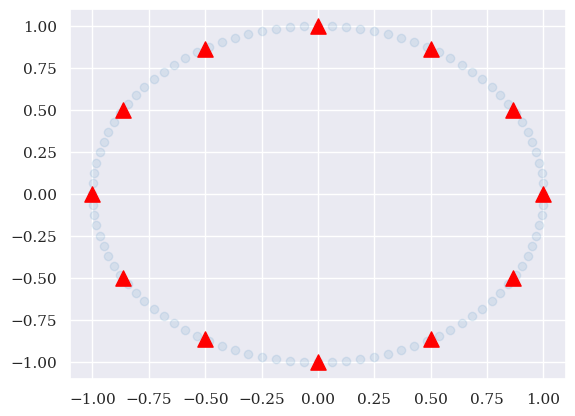

In [30]:
# test that it runs
start_data = sample_curve(100, curve_fn, sampling_mode="uniform_theta")
smoothing_param = 0.2
n_smoothing = 200

smoothed_score = get_smoothed_fn(lambda x, t, key: empirical_score_fn(x, Data, t), smoothing_param, n_smoothing)

xT, log_lik, log_lik_traj = log_likelihood_rev_prob_flow_smoothing(ve, start_data, empirical_score, smoothed_score, n_steps=1000, epsilon=1e-3, n_smoothing=100)
print(-log_lik)

plt.scatter(start_data[:, 0], start_data[:, 1], alpha=0.1, c='tab:blue')
plt.scatter(Data[:, 0], Data[:, 1], alpha=1, c='red', s=120, marker="^")

## now make the plots

In [31]:
DATA_SIZE = 12

Data = sample_curve(DATA_SIZE, curve_fn, sampling_mode="equally_spaced")    
empirical_score = lambda x, t, key : empirical_score_fn(x, Data, t)

smoothing_params = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

negative_log_likelihoods = []

# test points - points where we evaluate the negative log likelihood
num_samples = 1000
rng = jax.random.PRNGKey(0)
test_points = sample_curve(num_samples, curve_fn, sampling_mode="random", rng=rng)

n_steps = 100

for smoothing_param in smoothing_params:

    smoothed_score = get_smoothed_fn(empirical_score, smoothing_param, n_smoothing)
    
    xT, log_lik, lik_traj = log_likelihood_rev_prob_flow_smoothing(ve, test_points, empirical_score, smoothed_score, n_steps=n_steps, epsilon=1e-3, n_smoothing=1000, smoothing_param=smoothing_param)

    negative_log_likelihoods.append(-log_lik)

negative_log_likelihoods = jnp.array(negative_log_likelihoods)

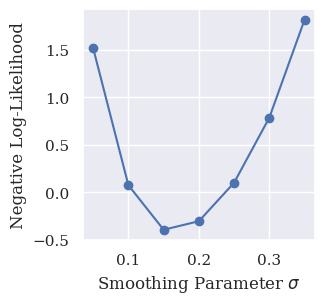

In [32]:
fig = plt.figure(figsize=(3, 3))

ave_log_likelihoods = jnp.mean(negative_log_likelihoods, axis=1)
plt.plot(smoothing_params, ave_log_likelihoods, marker='o')
plt.xlabel("Smoothing Parameter $\\sigma$")
plt.ylabel("Negative Log-Likelihood")

plt.savefig("figures/2d_circle_negative_log_likelihood.pdf", bbox_inches='tight')

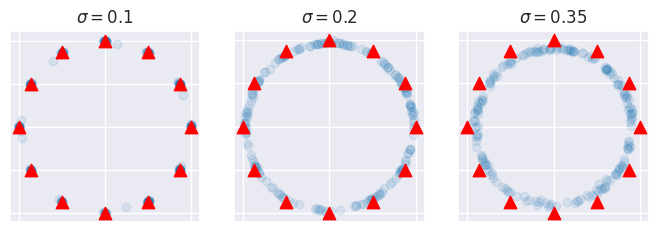

In [ ]:
# make some plots of the generations, for different smoothing parameters
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Define three parameter values
param_list = [0.1, 0.2, 0.35]

# hyperparams for the sampling
n_smoothing = 1000
n_steps = 100
num_samples = 200

# sampling uses eps_fn, rather than score_fn
data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, Data, t)
shape = (2,)

# Create a single row of 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(7, 2.5))

for idx, ax in enumerate(axes):  # Iterate over the 3 axes
    smoothing_param = param_list[idx]

    smoothed_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n_smoothing)
    samples, _ = sample_rev(ve, rng, smoothed_eps_fn, num_samples, image_shape=shape, num_steps=n_steps, add_last_noise=False)
    
    # Plot the samples
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.1, c='tab:blue', label="Generated Samples")
    ax.scatter(Data[:, 0], Data[:, 1], alpha=1, c='red', s=80, marker="^", label="Data Points")
    ax.set_title(f"$\\sigma={param_list[idx]}$")
    ax.set_aspect('equal', 'box')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Create legend handles with matching markers
scatter_blue = Line2D([], [], color='tab:blue', marker='o', linestyle='None', markersize=6, alpha=0.5, label='Generated Samples')
scatter_red = Line2D([], [], color='red', marker='^', linestyle='None', markersize=8, label='Data Points')

plt.tight_layout()
plt.savefig("figures/2d_circle_samples.pdf", bbox_inches='tight')

plt.show()